<a href="https://colab.research.google.com/github/PETEROA/AutoML/blob/main/NAS_controller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

implements the NAS algorithms to search for optimal model configurations.
- Load search space from Notebook 3
- Implement search algorithms:
  - Random Search (baseline)
  - Evolutionary Algorithm
  - Bayesian Optimization (optional)
- Quick evaluation of candidates
- Multi-objective optimization
- Generate Pareto-optimal solutions


In [ ]:
!pip install torch torchvision -q
!pip install matplotlib seaborn pandas numpy scipy -q
!pip install scikit-learn -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import time
from tqdm import tqdm
from typing import Dict, List, Any, Tuple
import copy
import warnings
warnings.filterwarnings('ignore')

# Import utilities
import sys
sys.path.append('/content/drive/MyDrive/AutoML')  # Adjust path

try:
    from Utils import *
    print("✓ Utils loaded")
except Exception as e:
    print(f"⚠ Utils not found: {e}")
    import traceback
    traceback.print_exc()

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Setup directories
OUTPUT_DIR = Path('/content/drive/MyDrive/AutoML/outputs')
CONFIGS_DIR = OUTPUT_DIR / 'configs'
RESULTS_DIR = OUTPUT_DIR / 'results'

print(f"Output directory: {OUTPUT_DIR}")

sys.path before import attempt: ['/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython', '/tmp/tmpo6ec9fwi', '/content/drive/MyDrive/AutoML', '/content/drive/MyDrive/AutoML', '/content/drive/MyDrive/AutoML', '/content/drive/MyDrive/AutoML', '/content/drive/MyDrive/AutoML', '/content/drive/MyDrive/AutoML', '/content/drive/MyDrive/AutoML', '/content/drive/MyDrive/AutoML', '/content/drive/MyDrive/AutoML', '/content/drive/MyDrive/AutoML', '/content/drive/MyDrive/AutoML', '/content/drive/MyDrive/AutoML']
⚠ Utils not found: No module named 'Utils'
Using device: cpu
Output directory: /content/drive/MyDrive/AutoML/outputs


Traceback (most recent call last):
  File "/tmp/ipython-input-2679878158.py", line 27, in <cell line: 0>
    from Utils import *
ModuleNotFoundError: No module named 'Utils'


In [ ]:
# Load Search Space config
# Load search space config from Notebook 3
search_space_file = CONFIGS_DIR / 'search_space_config.json'

if search_space_file.exists():
    with open(search_space_file, 'r') as f:
        search_space_config = json.load(f)
    print("✓ Loaded search space configuration from Notebook 3")
    print(f"\n  Total combinations: {search_space_config['metadata']['total_combinations']:,}")
    print(f"  Vector dimension: {search_space_config['metadata']['vector_dimension']}")
else:
    print("⚠ Search space config not found. Using default configuration.")
    # Create minimal config
    search_space_config = {
        'search_spaces': {
            'architecture': {
                'base_architectures': ['resnet18', 'mobilenet_v2'],
                'width_multipliers': [0.5, 0.75, 1.0],
                'depth_multipliers': [0.75, 1.0],
                'resolution_multipliers': [0.75, 1.0]
            },
            'distillation': {
                'loss_types': ['kl_divergence', 'mse'],
                'temperatures': [2.0, 3.0, 4.0],
                'alphas': [0.3, 0.5, 0.7],
                'use_distillation': [True, False]
            },
            'training': {
                'learning_rates': [0.0001, 0.001],
                'batch_sizes': [32, 64],
                'optimizers': ['adam', 'sgd']
            }
        },
        'objectives': {
            'weights': {
                'accuracy': 0.4,
                'latency': 0.3,
                'model_size': 0.2,
                'params': 0.1
            }
        }
    }

✓ Loaded search space configuration from Notebook 3

  Total combinations: 5,391,360
  Vector dimension: 0


In [ ]:
# Config Samplers
class ConfigurationSampler:
    """Sample configurations from the search space"""

    def __init__(self, search_space_config: Dict):
        self.search_space = search_space_config['search_spaces']

    def sample_random(self) -> Dict:
        """Sample a random configuration"""
        arch_space = self.search_space['architecture']
        distill_space = self.search_space['distillation']
        train_space = self.search_space['training']

        # Architecture
        arch_config = {
            'base_arch': np.random.choice(arch_space['base_architectures']),
            'width_mult': np.random.choice(arch_space['width_multipliers']),
            'depth_mult': np.random.choice(arch_space['depth_multipliers']),
            'resolution_mult': np.random.choice(arch_space['resolution_multipliers'])
        }

        # Distillation
        use_distill = np.random.choice(distill_space['use_distillation'])
        if use_distill:
            distill_config = {
                'use_distillation': True,
                'loss_type': np.random.choice(distill_space['loss_types']),
                'temperature': np.random.choice(distill_space['temperatures']),
                'alpha': np.random.choice(distill_space['alphas'])
            }
        else:
            distill_config = {
                'use_distillation': False,
                'loss_type': None,
                'temperature': None,
                'alpha': None
            }

        # Training
        train_config = {
            'learning_rate': np.random.choice(train_space['learning_rates']),
            'batch_size': np.random.choice(train_space['batch_sizes']),
            'optimizer': np.random.choice(train_space['optimizers'])
        }

        return {
            'architecture': arch_config,
            'distillation': distill_config,
            'training': train_config
        }

    def mutate(self, config: Dict, mutation_rate: float = 0.2) -> Dict:
        """Mutate a configuration"""
        new_config = copy.deepcopy(config)

        # Mutate architecture
        if np.random.random() < mutation_rate:
            key = np.random.choice(['base_arch', 'width_mult', 'depth_mult', 'resolution_mult'])
            if key == 'base_arch':
                new_config['architecture'][key] = np.random.choice(
                    self.search_space['architecture']['base_architectures']
                )
            else:
                param = key.replace('_mult', '_multipliers')
                new_config['architecture'][key] = np.random.choice(
                    self.search_space['architecture'][param]
                )

        # Mutate distillation
        if np.random.random() < mutation_rate and new_config['distillation']['use_distillation']:
            key = np.random.choice(['loss_type', 'temperature', 'alpha'])
            if key == 'loss_type':
                new_config['distillation'][key] = np.random.choice(
                    self.search_space['distillation']['loss_types']
                )
            elif key == 'temperature':
                new_config['distillation'][key] = np.random.choice(
                    self.search_space['distillation']['temperatures']
                )
            else:  # alpha
                new_config['distillation'][key] = np.random.choice(
                    self.search_space['distillation']['alphas']
                )

        # Mutate training
        if np.random.random() < mutation_rate:
            key = np.random.choice(['learning_rate', 'batch_size', 'optimizer'])
            if key == 'learning_rate':
                new_config['training'][key] = np.random.choice(
                    self.search_space['training']['learning_rates']
                )
            elif key == 'batch_size':
                new_config['training'][key] = np.random.choice(
                    self.search_space['training']['batch_sizes']
                )
            else:  # optimizer
                new_config['training'][key] = np.random.choice(
                    self.search_space['training']['optimizers']
                )

        return new_config

    def crossover(self, config1: Dict, config2: Dict) -> Dict:
        """Crossover two configurations"""
        new_config = copy.deepcopy(config1)

        # Randomly swap components
        if np.random.random() < 0.5:
            new_config['architecture'] = copy.deepcopy(config2['architecture'])

        if np.random.random() < 0.5:
            new_config['distillation'] = copy.deepcopy(config2['distillation'])

        if np.random.random() < 0.5:
            new_config['training'] = copy.deepcopy(config2['training'])

        return new_config

sampler = ConfigurationSampler(search_space_config)
print("\n✓ Configuration sampler ready")

# Test sampling
sample = sampler.sample_random()
print("\nExample sampled configuration:")
print(f"  Architecture: {sample['architecture']['base_arch']}")
print(f"  Distillation: {sample['distillation']['use_distillation']}")
print(f"  LR: {sample['training']['learning_rate']}")


✓ Configuration sampler ready

Example sampled configuration:
  Architecture: mobilenet_v2
  Distillation: True
  LR: 0.005


In [ ]:
# Quick Model Eval
# Prepare small dataset for quick evaluation
def get_quick_eval_data(batch_size=32):
    """Get small dataset for quick evaluation"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform
    )
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform
    )

    # Use small subsets for speed
    train_indices = torch.randperm(len(trainset))[:2000]  # 2000 samples
    test_indices = torch.randperm(len(testset))[:500]     # 500 samples

    train_subset = Subset(trainset, train_indices)
    test_subset = Subset(testset, test_indices)

    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader

print("Loading quick evaluation dataset...")
train_loader, test_loader = get_quick_eval_data()
print(f"✓ Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

Loading quick evaluation dataset...


100%|██████████| 170M/170M [00:10<00:00, 16.0MB/s]


✓ Train batches: 63, Test batches: 16


In [ ]:
class QuickEvaluator:
    """Quickly evaluate a configuration"""

    def __init__(self, trainloader, testloader, device='cuda', num_epochs=2):
        self.trainloader = trainloader
        self.testloader = testloader
        self.device = device
        self.num_epochs = num_epochs

    def create_model(self, config: Dict) -> nn.Module:
        """Create model from configuration"""
        arch = config['architecture']
        base_arch = arch['base_arch']

        # Load base model
        if base_arch == 'resnet18':
            model = models.resnet18(pretrained=False)
            model.fc = nn.Linear(model.fc.in_features, 10)
        elif base_arch == 'mobilenet_v2':
            model = models.mobilenet_v2(pretrained=False)
            model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)
        else:
            # Default to resnet18
            model = models.resnet18(pretrained=False)
            model.fc = nn.Linear(model.fc.in_features, 10)

        # Note: Width/depth scaling would require custom model implementation
        # For this demo, we use the base architecture

        return model

    def quick_train(self, model: nn.Module, config: Dict) -> Dict:
        """Quick training for evaluation"""
        model = model.to(self.device)
        model.train()

        # Setup optimizer
        lr = config['training']['learning_rate']
        if config['training']['optimizer'] == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        else:
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

        criterion = nn.CrossEntropyLoss()

        # Train for a few epochs
        for epoch in range(self.num_epochs):
            for images, labels in self.trainloader:
                images, labels = images.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluate
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in self.testloader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        accuracy = 100. * correct / total
        return accuracy

    def evaluate_config(self, config: Dict) -> Dict:
        """Evaluate a configuration and return metrics"""
        # Create and train model
        model = self.create_model(config)

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())

        # Estimate model size
        model_size_mb = total_params * 4 / (1024 ** 2)  # Assuming float32

        # Quick training
        accuracy = self.quick_train(model, config)

        # Measure latency
        model.eval()
        dummy_input = torch.randn(1, 3, 32, 32).to(self.device)

        # Warmup
        for _ in range(10):
            with torch.no_grad():
                _ = model(dummy_input)

        # Measure
        if self.device.type == 'cuda':
            torch.cuda.synchronize()

        start = time.time()
        with torch.no_grad():
            for _ in range(100):
                _ = model(dummy_input)
                if self.device.type == 'cuda':
                    torch.cuda.synchronize()
        latency_ms = (time.time() - start) / 100 * 1000

        # Cleanup
        del model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

        return {
            'accuracy': accuracy,
            'params': total_params,
            'model_size_mb': model_size_mb,
            'latency_ms': latency_ms
        }

evaluator = QuickEvaluator(train_loader, test_loader, device=device, num_epochs=2)
print("\n✓ Quick evaluator ready")


✓ Quick evaluator ready


In [ ]:
# Fitness Calculator
class FitnessCalculator:
    """Calculate fitness scores for multi-objective optimization"""

    def __init__(self, objective_weights: Dict):
        self.weights = objective_weights.get('weights', {
            'accuracy': 0.4,
            'latency': 0.3,
            'model_size': 0.2,
            'params': 0.1
        })

    def compute_fitness(self, metrics: Dict) -> float:
        """Compute weighted fitness score"""
        # Normalize metrics
        norm_accuracy = metrics['accuracy'] / 100.0  # 0-1 range
        norm_latency = 1.0 / (1.0 + metrics['latency_ms'] / 100.0)  # Lower is better
        norm_size = 1.0 / (1.0 + metrics['model_size_mb'] / 100.0)  # Lower is better
        norm_params = 1.0 / (1.0 + metrics['params'] / 1e7)  # Lower is better

        # Weighted sum
        fitness = (
            self.weights['accuracy'] * norm_accuracy +
            self.weights['latency'] * norm_latency +
            self.weights['model_size'] * norm_size +
            self.weights['params'] * norm_params
        )

        return fitness

fitness_calc = FitnessCalculator(search_space_config.get('objectives', {}))
print("✓ Fitness calculator ready")

✓ Fitness calculator ready


In [ ]:
# Search Algorithms
def random_search(sampler, evaluator, fitness_calc, num_samples=10):
    """Random search baseline"""
    print("\n" + "="*60)
    print("RANDOM SEARCH")
    print("="*60)

    results = []

    for i in tqdm(range(num_samples), desc="Random Search"):
        # Sample random configuration
        config = sampler.sample_random()

        # Evaluate
        metrics = evaluator.evaluate_config(config)
        fitness = fitness_calc.compute_fitness(metrics)

        results.append({
            'config': config,
            'metrics': metrics,
            'fitness': fitness
        })

        print(f"\nSample {i+1}: Acc={metrics['accuracy']:.2f}%, "
              f"Latency={metrics['latency_ms']:.2f}ms, Fitness={fitness:.4f}")

    # Sort by fitness
    results.sort(key=lambda x: x['fitness'], reverse=True)

    return results

In [ ]:
# Evolutionary Algorithm
def evolutionary_search(
    sampler,
    evaluator,
    fitness_calc,
    population_size=10,
    num_generations=5,
    mutation_rate=0.2,
    elite_size=2
):
    """Evolutionary algorithm for NAS"""
    print("\n" + "="*60)
    print("EVOLUTIONARY SEARCH")
    print("="*60)
    print(f"Population: {population_size}, Generations: {num_generations}")

    # Initialize population
    print("\nInitializing population...")
    population = []
    for i in tqdm(range(population_size), desc="Initial Population"):
        config = sampler.sample_random()
        metrics = evaluator.evaluate_config(config)
        fitness = fitness_calc.compute_fitness(metrics)
        population.append({
            'config': config,
            'metrics': metrics,
            'fitness': fitness
        })

    # Sort by fitness
    population.sort(key=lambda x: x['fitness'], reverse=True)

    best_history = [population[0]['fitness']]
    avg_history = [np.mean([ind['fitness'] for ind in population])]

    print(f"Initial best fitness: {population[0]['fitness']:.4f}")

    # Evolution
    for gen in range(num_generations):
        print(f"\n{'='*60}")
        print(f"Generation {gen + 1}/{num_generations}")
        print(f"{'='*60}")

        new_population = []

        # Elitism: keep best individuals
        new_population.extend(population[:elite_size])

        # Generate offspring
        pbar = tqdm(range(population_size - elite_size), desc=f"Gen {gen+1}")
        for _ in pbar:
            # Tournament selection
            parent1 = max(np.random.choice(population, 3, replace=False),
                         key=lambda x: x['fitness'])
            parent2 = max(np.random.choice(population, 3, replace=False),
                         key=lambda x: x['fitness'])

            # Crossover
            child_config = sampler.crossover(parent1['config'], parent2['config'])

            # Mutation
            if np.random.random() < 0.8:  # 80% chance of mutation
                child_config = sampler.mutate(child_config, mutation_rate)

            # Evaluate
            try:
                metrics = evaluator.evaluate_config(child_config)
                fitness = fitness_calc.compute_fitness(metrics)
                new_population.append({
                    'config': child_config,
                    'metrics': metrics,
                    'fitness': fitness
                })
            except Exception as e:
                # If evaluation fails, create random individual
                config = sampler.sample_random()
                metrics = evaluator.evaluate_config(config)
                fitness = fitness_calc.compute_fitness(metrics)
                new_population.append({
                    'config': config,
                    'metrics': metrics,
                    'fitness': fitness
                })

        # Update population
        population = sorted(new_population, key=lambda x: x['fitness'], reverse=True)

        # Track history
        best_fitness = population[0]['fitness']
        avg_fitness = np.mean([ind['fitness'] for ind in population])
        best_history.append(best_fitness)
        avg_history.append(avg_fitness)

        print(f"\nBest fitness: {best_fitness:.4f}")
        print(f"Average fitness: {avg_fitness:.4f}")
        print(f"Best accuracy: {population[0]['metrics']['accuracy']:.2f}%")

    return population, best_history, avg_history

In [ ]:
# Run Search Algorithm
# Run Random Search
random_results = random_search(
    sampler,
    evaluator,
    fitness_calc,
    num_samples=10
)

print(f"\n{'='*60}")
print("Random Search Complete")
print(f"Best fitness: {random_results[0]['fitness']:.4f}")
print(f"Best accuracy: {random_results[0]['metrics']['accuracy']:.2f}%")


RANDOM SEARCH


Random Search:  10%|█         | 1/10 [01:07<10:05, 67.22s/it]


Sample 1: Acc=32.60%, Latency=9.66ms, Fitness=0.5914


Random Search:  20%|██        | 2/10 [02:14<08:56, 67.12s/it]


Sample 2: Acc=32.00%, Latency=13.82ms, Fitness=0.5790


Random Search:  30%|███       | 3/10 [03:31<08:21, 71.67s/it]


Sample 3: Acc=22.20%, Latency=10.19ms, Fitness=0.5485


Random Search:  40%|████      | 4/10 [04:54<07:37, 76.32s/it]


Sample 4: Acc=36.60%, Latency=9.73ms, Fitness=0.6072


Random Search:  50%|█████     | 5/10 [06:11<06:22, 76.44s/it]


Sample 5: Acc=28.80%, Latency=10.29ms, Fitness=0.5746


Random Search:  60%|██████    | 6/10 [06:57<04:24, 66.09s/it]


Sample 6: Acc=25.60%, Latency=8.90ms, Fitness=0.6439


Random Search:  70%|███████   | 7/10 [07:42<02:57, 59.15s/it]


Sample 7: Acc=19.20%, Latency=9.44ms, Fitness=0.6169


Random Search:  80%|████████  | 8/10 [09:01<02:10, 65.46s/it]


Sample 8: Acc=37.40%, Latency=9.76ms, Fitness=0.6103


Random Search:  90%|█████████ | 9/10 [09:43<00:58, 58.22s/it]


Sample 9: Acc=10.80%, Latency=9.52ms, Fitness=0.5831


Random Search: 100%|██████████| 10/10 [11:02<00:00, 66.23s/it]


Sample 10: Acc=35.60%, Latency=9.99ms, Fitness=0.6026

Random Search Complete
Best fitness: 0.6439
Best accuracy: 25.60%


In [ ]:
# Run Evolutionary Search
evo_population, evo_best_history, evo_avg_history = evolutionary_search(
    sampler,
    evaluator,
    fitness_calc,
    population_size=10,
    num_generations=5,
    mutation_rate=0.2,
    elite_size=2
)

print(f"\n{'='*60}")
print("Evolutionary Search Complete")
print(f"Best fitness: {evo_population[0]['fitness']:.4f}")
print(f"Best accuracy: {evo_population[0]['metrics']['accuracy']:.2f}%")


EVOLUTIONARY SEARCH
Population: 10, Generations: 5

Initializing population...


Initial Population: 100%|██████████| 10/10 [09:51<00:00, 59.10s/it]


Initial best fitness: 0.6139

Generation 1/5


Gen 1: 100%|██████████| 8/8 [07:49<00:00, 58.66s/it]



Best fitness: 0.6139
Average fitness: 0.5960
Best accuracy: 18.20%

Generation 2/5


Gen 2: 100%|██████████| 8/8 [06:58<00:00, 52.35s/it]



Best fitness: 0.6167
Average fitness: 0.6059
Best accuracy: 39.20%

Generation 3/5


Gen 3: 100%|██████████| 8/8 [07:45<00:00, 58.13s/it]



Best fitness: 0.6167
Average fitness: 0.5911
Best accuracy: 39.20%

Generation 4/5


Gen 4: 100%|██████████| 8/8 [07:36<00:00, 57.05s/it]



Best fitness: 0.6187
Average fitness: 0.6105
Best accuracy: 19.40%

Generation 5/5


Gen 5: 100%|██████████| 8/8 [08:01<00:00, 60.19s/it]


Best fitness: 0.6263
Average fitness: 0.6069
Best accuracy: 21.40%

Evolutionary Search Complete
Best fitness: 0.6263
Best accuracy: 21.40%


In [ ]:
# Compare Search Methods
print("\n" + "="*60)
print("SEARCH ALGORITHM COMPARISON")
print("="*60)

print(f"\nRandom Search:")
print(f"  Best Fitness: {random_results[0]['fitness']:.4f}")
print(f"  Best Accuracy: {random_results[0]['metrics']['accuracy']:.2f}%")
print(f"  Best Latency: {random_results[0]['metrics']['latency_ms']:.2f}ms")

print(f"\nEvolutionary Search:")
print(f"  Best Fitness: {evo_population[0]['fitness']:.4f}")
print(f"  Best Accuracy: {evo_population[0]['metrics']['accuracy']:.2f}%")
print(f"  Best Latency: {evo_population[0]['metrics']['latency_ms']:.2f}ms")

improvement = ((evo_population[0]['fitness'] - random_results[0]['fitness']) /
               random_results[0]['fitness'] * 100)
print(f"\nEvolutionary improvement: {improvement:+.2f}%")


SEARCH ALGORITHM COMPARISON

Random Search:
  Best Fitness: 0.6439
  Best Accuracy: 25.60%
  Best Latency: 8.90ms

Evolutionary Search:
  Best Fitness: 0.6263
  Best Accuracy: 21.40%
  Best Latency: 9.21ms

Evolutionary improvement: -2.73%


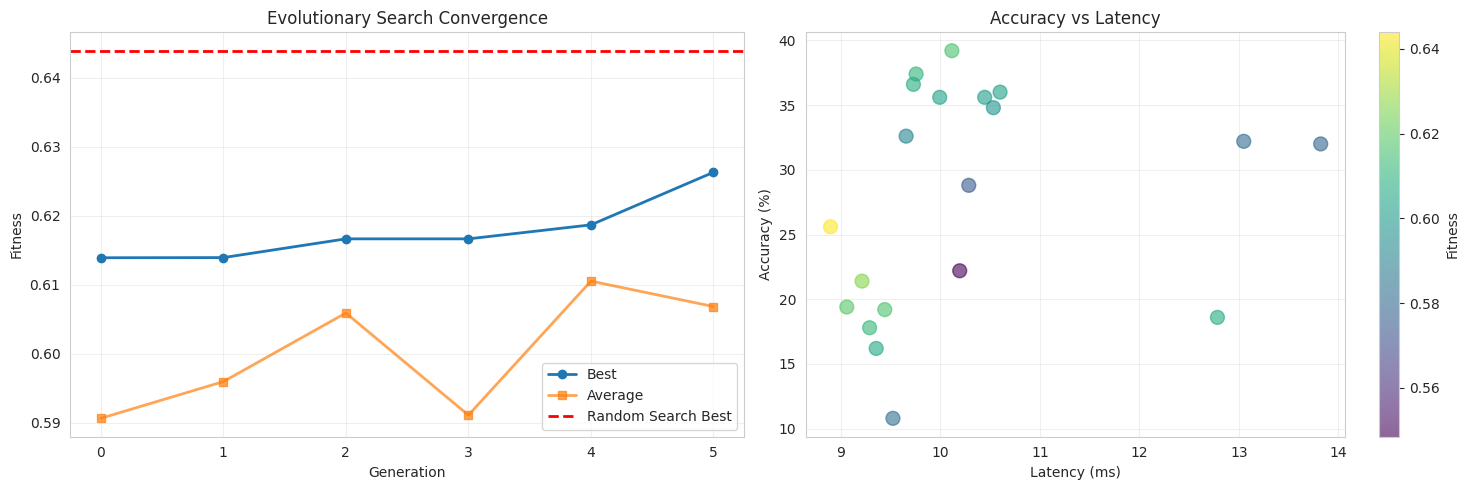


✓ Visualization saved


In [ ]:
# Visualizations
# Plot convergence
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Evolutionary convergence
axes[0].plot(evo_best_history, marker='o', label='Best', linewidth=2)
axes[0].plot(evo_avg_history, marker='s', label='Average', linewidth=2, alpha=0.7)
axes[0].axhline(y=random_results[0]['fitness'], color='r', linestyle='--',
                label='Random Search Best', linewidth=2)
axes[0].set_xlabel('Generation')
axes[0].set_ylabel('Fitness')
axes[0].set_title('Evolutionary Search Convergence')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Pareto frontier (Accuracy vs Latency)
all_results = random_results + evo_population
accuracies = [r['metrics']['accuracy'] for r in all_results]
latencies = [r['metrics']['latency_ms'] for r in all_results]
fitness_scores = [r['fitness'] for r in all_results]

scatter = axes[1].scatter(latencies, accuracies, c=fitness_scores,
                         cmap='viridis', s=100, alpha=0.6)
axes[1].set_xlabel('Latency (ms)')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy vs Latency')
plt.colorbar(scatter, ax=axes[1], label='Fitness')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'nas_search_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved")

In [ ]:
# Save Best Configs

def convert_numpy_types(obj):
    """Recursively convert numpy types to native Python types."""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(elem) for elem in obj]
    else:
        return obj

# Select top configurations
all_results = random_results + evo_population
all_results.sort(key=lambda x: x['fitness'], reverse=True)

# Save top 5 configurations
top_configs = []
for i, result in enumerate(all_results[:5]):
    # Convert config to ensure all numpy types are handled
    converted_config = convert_numpy_types(result['config'])

    config_data = {
        'rank': i + 1,
        'config': converted_config,
        'metrics': {
            'accuracy': float(result['metrics']['accuracy']),
            'params': int(result['metrics']['params']),
            'model_size_mb': float(result['metrics']['model_size_mb']),
            'latency_ms': float(result['metrics']['latency_ms'])
        },
        'fitness': float(result['fitness'])
    }
    top_configs.append(config_data)

# Save to file
with open(CONFIGS_DIR / 'best_nas_configs.json', 'w') as f:
    json.dump(top_configs, f, indent=2)

print("\n" + "="*60)
print("TOP 5 CONFIGURATIONS")
print("="*60)

for config_data in top_configs:
    print(f"\nRank {config_data['rank']}:")
    print(f"  Fitness: {config_data['fitness']:.4f}")
    print(f"  Accuracy: {config_data['metrics']['accuracy']:.2f}%")
    print(f"  Latency: {config_data['metrics']['latency_ms']:.2f}ms")
    print(f"  Model Size: {config_data['metrics']['model_size_mb']:.2f}MB")
    print(f"  Params: {config_data['metrics']['params']:,}")

print(f"\n✓ Saved to: {CONFIGS_DIR / 'best_nas_configs.json'}")


TOP 5 CONFIGURATIONS

Rank 1:
  Fitness: 0.6439
  Accuracy: 25.60%
  Latency: 8.90ms
  Model Size: 8.53MB
  Params: 2,236,682

Rank 2:
  Fitness: 0.6263
  Accuracy: 21.40%
  Latency: 9.21ms
  Model Size: 8.53MB
  Params: 2,236,682

Rank 3:
  Fitness: 0.6187
  Accuracy: 19.40%
  Latency: 9.06ms
  Model Size: 8.53MB
  Params: 2,236,682

Rank 4:
  Fitness: 0.6169
  Accuracy: 19.20%
  Latency: 9.44ms
  Model Size: 8.53MB
  Params: 2,236,682

Rank 5:
  Fitness: 0.6167
  Accuracy: 39.20%
  Latency: 10.12ms
  Model Size: 42.65MB
  Params: 11,181,642

✓ Saved to: /content/drive/MyDrive/AutoML/outputs/configs/best_nas_configs.json


In [ ]:
# Create summary dataframe
summary_data = []
for i, config in enumerate(top_configs):
    summary_data.append({
        'Rank': i + 1,
        'Architecture': config['config']['architecture']['base_arch'],
        'Width': config['config']['architecture']['width_mult'],
        'Accuracy': f"{config['metrics']['accuracy']:.2f}%",
        'Latency': f"{config['metrics']['latency_ms']:.2f}ms",
        'Size': f"{config['metrics']['model_size_mb']:.2f}MB",
        'Params': f"{config['metrics']['params']/1e6:.2f}M",
        'Fitness': f"{config['fitness']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(RESULTS_DIR / 'nas_top_configs.csv', index=False)

print("\n" + "="*60)
print("NAS SUMMARY TABLE")
print("="*60)
print(summary_df.to_string(index=False))

print(f"\n✓ Summary saved to: {RESULTS_DIR / 'nas_top_configs.csv'}")


NAS SUMMARY TABLE
 Rank Architecture  Width Accuracy Latency    Size Params Fitness
    1 mobilenet_v2   0.50   25.60%  8.90ms  8.53MB  2.24M  0.6439
    2 mobilenet_v2   1.00   21.40%  9.21ms  8.53MB  2.24M  0.6263
    3 mobilenet_v2   1.00   19.40%  9.06ms  8.53MB  2.24M  0.6187
    4 mobilenet_v2   1.00   19.20%  9.44ms  8.53MB  2.24M  0.6169
    5     resnet18   0.75   39.20% 10.12ms 42.65MB 11.18M  0.6167

✓ Summary saved to: /content/drive/MyDrive/AutoML/outputs/results/nas_top_configs.csv
